## Setup Environment

In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.8/882.8 kB 33.9 MB/s eta 0:00:00


In [2]:
import cv2
from ultralytics import YOLO, solutions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Load the YOLO Model

In [3]:
model = YOLO('yolov10m.pt')

100%|██████████| 32.1M/32.1M [00:00<00:00, 218MB/s]


## Prepare the Video Capture

In [4]:
cap = cv2.VideoCapture('/content/HighWay.MP4')
assert cap.isOpened(), 'The file dose not Found'

## Get Video Information

You can use `cv2` library to get these information fro the `VideoCapture()` variable you created to extract these information:
* `height`: Video's height.
* `width`: Video's width.
* `fps`: Video's frames.

In [5]:
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

## Prepare Video Writer to Store the Output

Create a variable that uses `cv2.VideoCapture()` to save the video with the bounding boxes, specified Region of Interest rectangle (ROI) and the counted vehicles on each sides. You will need to make the video with the same `fps`, `width`, `height`, and specify the codec and output path of the video.

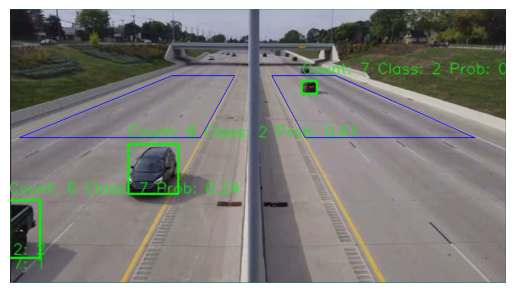

In [ ]:
# Load your image (replace 'path_to_image' with your actual image path)
image = cv2.imread('/content/Screenshot 2024-10-04 191341.png')

# Check if the image was loaded properly
if image is None:
    print("Error loading image!")
else:
    # Define region points (make sure this is an array of the right shape)
    region_points_right = np.array([[1056, 460], [1664, 460], [1166, 238], [937, 238]])
    region_points_left = np.array([[580, 238], [804, 238], [682, 460], [33, 460]])

    # Create a copy of the image to draw on
    image_with_points = image.copy()

    # Draw the polygon for the region
    cv2.polylines(image_with_points, [region_points_left,region_points_right], isClosed=True, color=(255, 0, 0), thickness=2)

    # Display the image with the region
    plt.imshow(cv2.cvtColor(image_with_points, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [6]:
# Video writer
video_writer = cv2.VideoWriter("count_video.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

# Define your ROI points
region_points_right = np.array([
    (1056, 460),  # Top-left
    (1644, 460),  # Top-right
    (1166, 238),  # Bottom-right
    (937, 238)   # Bottom-left
])

region_points_left = np.array([
    (755, 460),  # Top-left
    (122, 460),   # Top-right
    (580, 238),  # Bottom-right
    (874, 238)  # Bottom-left
])

# Resolutions -> To display ROI in correct position in the Video
video_width = 1920
video_height = 886
image_width = 1776
image_height = 981

# Calculate scaling factors
scale_x = video_width / image_width  # Width scaling factor
scale_y = video_height / image_height  # Height scaling factor

# Scaling factors
scale_x = video_width / image_width
scale_y = video_height / image_height

# Scale the ROI points
scaled_region_points_right = (region_points_right * [scale_x, scale_y]).astype(int)
scaled_region_points_left = (region_points_left * [scale_x, scale_y]).astype(int)


# Other parameters
color = (178, 27, 162)
thickness = 2
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
font_thickness = 1

## Process Video Frames and Identify Vehicles

In [ ]:
# Initialize the DataFrame to store car IDs and maximum speeds
df = pd.DataFrame(columns=['Car ID', 'Max Speed (km/h)', 'ROI'])

# Constants
conversion_factor = 0.0233  # real-world measurements (meters per pixel)
frame_rate = 59
speed_buffer_size = 5  # Number of frames to average speed over

# Initialize dictionaries to track positions and speeds
previous_positions = {}
speeds = {}
max_speeds = {}
buffer_positions = {}
buffer_speeds = {}

# Initialize ROI counts and tracked IDs
count_right = 0
count_left = 0
tracked_ids_right = set()
tracked_ids_left = set()

ret = True
while ret:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, persist=True)

    for result in results:
        for obj in result.boxes:
            bbox = obj.xyxy[0].cpu().numpy()
            class_id = int(obj.cls[0].cpu().numpy()) if obj.cls is not None else -1
            obj_id = int(obj.id[0].cpu().numpy()) if obj.id is not None else -1

            if class_id == 2:  # Assuming class_id 2 represents cars
                x1, y1, x2, y2 = map(int, bbox)
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2

                # Initialize buffers for this object if not already done
                if obj_id not in buffer_positions:
                    buffer_positions[obj_id] = []
                    buffer_speeds[obj_id] = []
                    max_speeds[obj_id] = 0.0

                buffer_positions[obj_id].append((center_x, center_y))
                if len(buffer_positions[obj_id]) > 10:  # Keep a larger history
                    buffer_positions[obj_id].pop(0)

                # Speed calculation for both ROIs
                # (Right ROI)
                if (cv2.pointPolygonTest(scaled_region_points_right, (x1, y1), False) >= 0 or
                    cv2.pointPolygonTest(scaled_region_points_right, (x2, y2), False) >= 0):

                    if obj_id not in tracked_ids_right:
                        tracked_ids_right.add(obj_id)
                        count_right += 1

                    # Speed calculation
                    if obj_id not in previous_positions:
                        previous_positions[obj_id] = (center_x, center_y)
                    else:
                        if len(buffer_positions[obj_id]) > 1:
                            prev_center = buffer_positions[obj_id][-2]
                            current_center = buffer_positions[obj_id][-1]
                            distance = np.sqrt((current_center[0] - prev_center[0]) ** 2 + (current_center[1] - prev_center[1]) ** 2) * conversion_factor
                            speed = (distance / (1 / frame_rate)) * 3.6  # Convert m/s to km/h

                            buffer_speeds[obj_id].append(speed)
                            if len(buffer_speeds[obj_id]) > speed_buffer_size:
                                buffer_speeds[obj_id].pop(0)

                            # Calculate the average speed
                            speeds[obj_id] = np.mean(buffer_speeds[obj_id])

                            previous_positions[obj_id] = current_center

                            # Update max speed if current speed is greater
                            if speeds[obj_id] > max_speeds[obj_id]:
                                max_speeds[obj_id] = speeds[obj_id]

                    # Draw bounding box and speed label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
                    label = f'{speeds[obj_id]:.2f} km/h' if obj_id in speeds else 'Speed: N/A'
                    cv2.putText(frame, label, (x1, y1 - 10), font, font_scale, color, 2, cv2.LINE_AA)

                # (Left ROI)
                if (cv2.pointPolygonTest(scaled_region_points_left, (x1, y1), False) >= 0 or
                    cv2.pointPolygonTest(scaled_region_points_left, (x2, y2), False) >= 0):

                    if obj_id not in tracked_ids_left:
                        tracked_ids_left.add(obj_id)
                        count_left += 1

                    # Speed calculation
                    if obj_id not in previous_positions:
                        previous_positions[obj_id] = (center_x, center_y)
                    else:
                        if len(buffer_positions[obj_id]) > 1:
                            prev_center = buffer_positions[obj_id][-2]
                            current_center = buffer_positions[obj_id][-1]
                            distance = np.sqrt((current_center[0] - prev_center[0]) ** 2 + (current_center[1] - prev_center[1]) ** 2) * conversion_factor
                            speed = (distance / (1 / frame_rate)) * 3.6

                            buffer_speeds[obj_id].append(speed)
                            if len(buffer_speeds[obj_id]) > speed_buffer_size:
                                buffer_speeds[obj_id].pop(0)

                            # Calculate the average speed
                            speeds[obj_id] = np.mean(buffer_speeds[obj_id])

                            previous_positions[obj_id] = current_center

                            # Update max speed if current speed is greater
                            if speeds[obj_id] > max_speeds[obj_id]:
                                max_speeds[obj_id] = speeds[obj_id]

                    # Draw bounding box and speed label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
                    label = f'{speeds[obj_id]:.2f} km/h' if obj_id in speeds else 'Speed: N/A'
                    cv2.putText(frame, label, (x1, y1 - 10), font, font_scale, color, 2, cv2.LINE_AA)

    # Draw total counts
    total_label_right = f'Total Cars Right: {count_right}'
    total_label_left = f'Total Cars Left: {count_left}'
    cv2.putText(frame, total_label_right, (10, height - 40), font, font_scale, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, total_label_left, (10, height - 20), font, font_scale, (255, 255, 255), 2, cv2.LINE_AA)

    # Write the frame to the video
    video_writer.write(frame)

cap.release()
video_writer.release()

# Print total counts for debugging
print(f"Total Cars Left: {count_left}")
print(f"Total Cars Right: {count_right}")

# After processing all frames, create a list to store data for the DataFrame
data = []

for obj_id in max_speeds:
    if obj_id in tracked_ids_right:
        roi = 'Right'
    elif obj_id in tracked_ids_left:
        roi = 'Left'
    else:
        roi = 'Unknown'

    data.append({'Car ID': obj_id, 'Max Speed (km/h)': max_speeds[obj_id], 'ROI': roi})

df = pd.DataFrame(data)

# Optionally save the DataFrame to a CSV file
df.to_csv('max_speeds.csv', index=False)

cv2.destroyAllWindows()


Streaming output truncated to the last 5000 lines.

0: 320x640 5 cars, 1 truck, 717.8ms
Speed: 3.6ms preprocess, 717.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 cars, 1 truck, 649.7ms
Speed: 3.5ms preprocess, 649.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 663.2ms
Speed: 3.1ms preprocess, 663.2ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 715.3ms
Speed: 3.4ms preprocess, 715.3ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 cars, 1 truck, 646.1ms
Speed: 3.1ms preprocess, 646.1ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 cars, 2 trucks, 655.3ms
Speed: 3.1ms preprocess, 655.3ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 5 cars, 1 truck, 692.2ms
Speed: 6.3ms preprocess, 692.2ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 6 cars, 1

## Show Data

###EDA

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/max_speeds (2).csv')

df = df[df['ROI'] != 'Unknown'] # Drop Unknown values

df_left = pd.DataFrame()
df_right = pd.DataFrame()


for index, row in df.iterrows(): # Iterate over the rows of the dataframe
  if row['ROI'] == 'Left': # Check the value in the 'ROI' column
    df_left = pd.concat([df_left, pd.DataFrame([row])], ignore_index=True) # Concatenate the current row to df_left

for index, row in df.iterrows(): # Iterate over the rows of the dataframe
  if row['ROI'] == 'Right': # Check the value in the 'ROI' column
    df_right = pd.concat([df_right, pd.DataFrame([row])], ignore_index=True) # Concatenate the current row to df_right

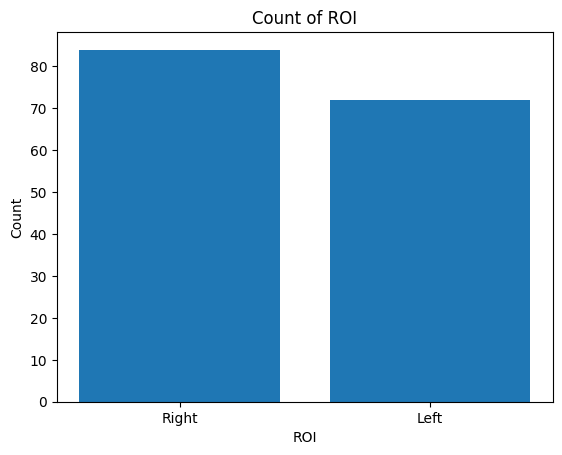

In [13]:
# Assuming your dataframe is named 'df'
roi_counts = df['ROI'].value_counts()

# Create the bar chart
plt.bar(roi_counts.index, roi_counts.values)
plt.xlabel('ROI')
plt.ylabel('Count')
plt.title('Count of ROI')
plt.show()

In [14]:
import pandas as pd

count_right = len(df[df['ROI'] == 'Right'])
print(f'Car count for the right: {count_right}')

count_left = len(df[df['ROI'] == 'Left'])
print(f'Car count for the left: {count_left}')


average_speed_right = df[df['ROI'] == 'Right']['Max Speed (km/h)'].mean()
print(f'\naverage speed for the right: {average_speed_right}')

average_speed_left = df[df['ROI'] == 'Left']['Max Speed (km/h)'].mean()
print(f'average speed for the left: {average_speed_left}')

traffic_status_right = 'Heavy' if count_right >= 20 and average_speed_right <= 10 else 'Moderate' if count_right < 40 else 'Light'
print(f'\n\nTraffic Status for the right: {traffic_status_right}')

traffic_status_left = 'Heavy' if count_left >= 20 and average_speed_left <= 10 else 'Moderate' if count_left < 40 else 'Light'
print(f'Traffic Status for the left: {traffic_status_left}')


Car count for the right: 84
Car count for the left: 72

average speed for the right: 81.00151489257466
average speed for the left: 76.40278163422141


Traffic Status for the right: Light
Traffic Status for the left: Light


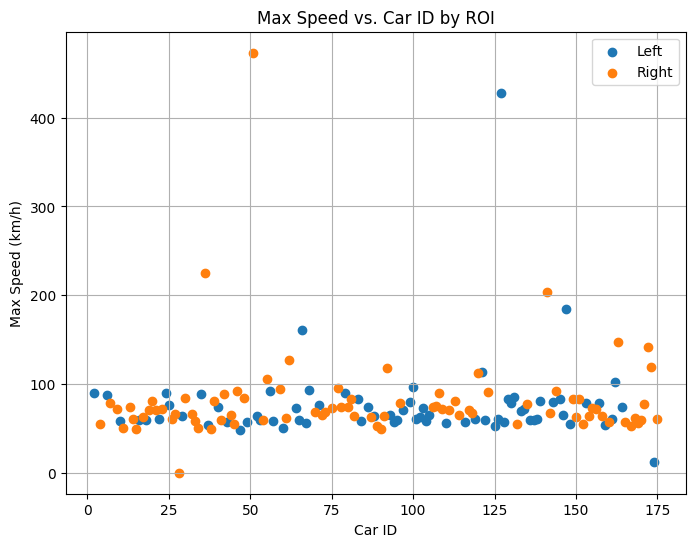

In [15]:
# Create a scatter plot of Max Speed vs. Car ID for each ROI
plt.figure(figsize=(8, 6))
for roi in df['ROI'].unique():
  df_roi = df[df['ROI'] == roi]
  # Use 'Car ID' for the x-axis instead of 'Count'
  plt.scatter(df_roi['Car ID'], df_roi['Max Speed (km/h)'], label=roi)

plt.xlabel('Car ID') # Update x-axis label
plt.ylabel('Max Speed (km/h)')
plt.title('Max Speed vs. Car ID by ROI') # Update title
plt.legend()
plt.grid(True)
plt.show()